<h3>Twtter data Sentiment Analysis

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



# List files in the dataset directory and pick a supported file
supported_exts = [
    ".csv", ".tsv", ".json", ".jsonl", ".xml", ".parquet", ".feather",
    ".sqlite", ".sqlite3", ".db", ".db3", ".s3db", ".dl3",
    ".xls", ".xlsx", ".xlsm", ".xlsb", ".odf", ".ods", ".odt"
]
dataset_files = [f for f in os.listdir(path) if os.path.splitext(f)[1] in supported_exts]

if not dataset_files:
    raise ValueError("No supported dataset files found in the directory.")

file_path = os.path.join(path, dataset_files[0])

# Load the latest version
import pandas as pd

df = pd.read_csv(file_path)

print("First 5 records:", df.head())

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'path' is not defined

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Auto-load dataset
supported_exts = [".csv", ".tsv", ".json", ".jsonl"]
dataset_files = [f for f in os.listdir(path) if os.path.splitext(f)[1] in supported_exts]
if not dataset_files:
    raise ValueError("❌ No supported dataset files found in directory.")
file_path = os.path.join(path, dataset_files[0])

# Load
df = pd.read_csv(file_path)
print("📄 Shape:", df.shape)
df.head()


[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📄 Shape: (162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
# Guess text and label columns
text_col = next((col for col in df.columns if df[col].dtype == 'object' and df[col].str.len().mean() > 20), None)
label_col = next((col for col in df.columns if df[col].nunique() <= 5 and df[col].dtype in ['object', 'category', 'int', 'float']), None)

print(f"📌 Detected text column: {text_col}")
print(f"🏷️ Detected label column: {label_col}")

if not text_col or not label_col:
    raise Exception("❌ Could not automatically detect text/label columns.")


📌 Detected text column: clean_text
🏷️ Detected label column: category


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return " ".join([w for w in text.split() if w not in stop_words])

# Clean text
df["clean_text"] = df[text_col].apply(clean_text)
df = df.dropna(subset=["clean_text", label_col])
df = df[df["clean_text"] != ""]

print("✅ Cleaned data shape:", df.shape)


✅ Cleaned data shape: (162897, 2)


/var/folders/cm/9rjzvcbn783456m0cwxvszdh0000gn/T/ipykernel_3669/1822048100.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_col, data=df, palette="viridis")


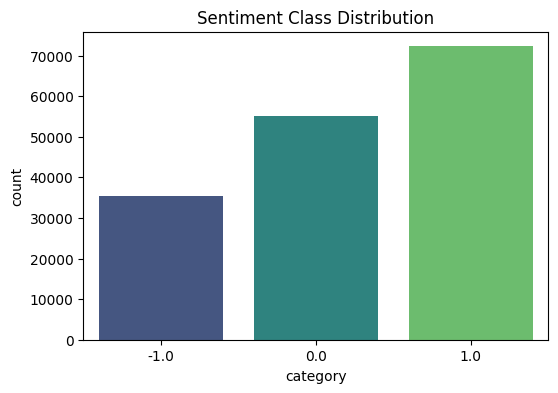

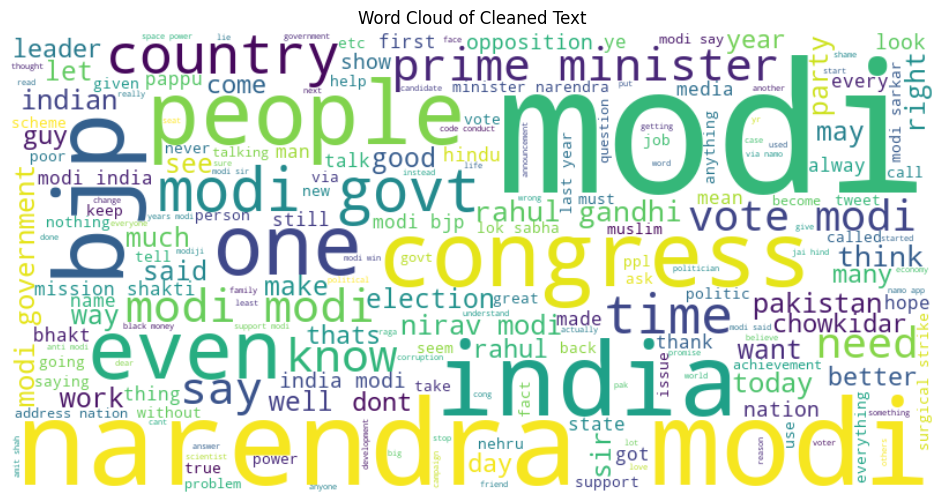

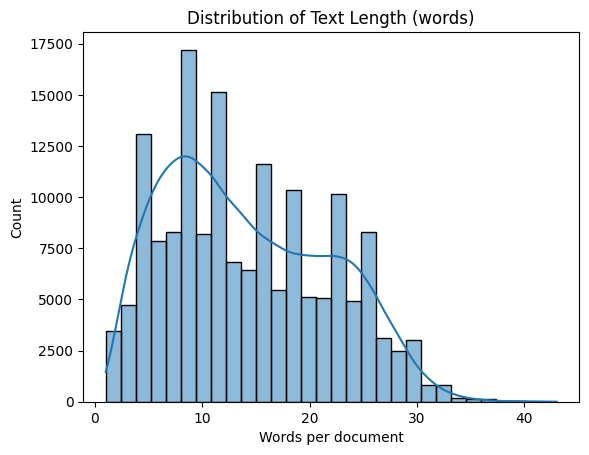

In [ ]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=label_col, data=df, palette="viridis")
plt.title("Sentiment Class Distribution")
plt.show()

# Word Cloud
all_text = " ".join(df["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Cleaned Text")
plt.show()

# Text Length
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
sns.histplot(df["text_length"], bins=30, kde=True)
plt.title("Distribution of Text Length (words)")
plt.xlabel("Words per document")
plt.show()


In [ ]:
X = df["clean_text"]
y = df[label_col]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectorize
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [ ]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds = nb_model.predict(X_test_vec)

# SVM
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
svm_preds = svm_model.predict(X_test_vec)


In [ ]:
def evaluate_model(y_true, y_pred, title="Model"):
    print(f"\n🔍 {title} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, nb_preds, "Naive Bayes")
evaluate_model(y_test, svm_preds, "SVM")



🔍 Naive Bayes Evaluation
Accuracy: 0.733486801718846
Confusion Matrix:
 [[ 3131   655  3316]
 [  129  7359  3541]
 [  335   707 13407]]
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.87      0.44      0.59      7102
         0.0       0.84      0.67      0.75     11029
         1.0       0.66      0.93      0.77     14449

    accuracy                           0.73     32580
   macro avg       0.79      0.68      0.70     32580
weighted avg       0.77      0.73      0.72     32580


🔍 SVM Evaluation
Accuracy: 0.9030079803560467
Confusion Matrix:
 [[ 5813   579   710]
 [  143 10732   154]
 [  681   893 12875]]
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.88      0.82      0.85      7102
         0.0       0.88      0.97      0.92     11029
         1.0       0.94      0.89      0.91     14449

    accuracy                           0.90     32580
   macro avg       0.90      0.8